In [1]:
import torch
print(torch.__version__)

1.9.1


In [2]:
pip install torchattacks

     |████████████████████████████████| 102 kB 1.1 MB/s           
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision --upgrade

     |████████████████████████████████| 23.2 MB 892 kB/s            
     |████████████████████████████████| 881.9 MB 1.4 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import os.path as osp
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [7]:
df = pd.read_csv("../input/cancer-detection/train_labels.csv")
len(df)

220025

In [8]:
df[df.duplicated(keep=False)]
len(df)

220025

In [9]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Custom Image Dataset

In [10]:
train_path = '../input/cancer-detection/train'
test_path = '../input/cancer-detection/test'

from sklearn.model_selection import train_test_split

train, val = train_test_split(df, 
                              stratify=df.label, 
                              test_size=0.2)

_, fgsm_train = train_test_split(train, stratify=train.label, test_size=0.3)

print("train size: ", len(train))
print("val size: ", len(val))
print("fgsm_train size: ", len(fgsm_train))

train size:  176020
val size:  44005
fgsm_train size:  52806


## 1. Normal ImageDataset

In [11]:
import cv2
import matplotlib.image as mpimg
from matplotlib.colors import Normalize

In [12]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, knn=False):
        super().__init__()
        self.df = df.values
        self.image_dir = image_dir
        self.transform = transform
        self.knn = knn
    
    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.image_dir, img_name + '.tif')
        
        # image for knn classifier
        if self.knn is True:
            img = mpimg.imread(img_path)
            return img, label
            
        # Torch Tensor
        else:
            img = Image.open(img_path) # PIL image read
            img = self.transform(img)
        
        return img, label
    
    def __len__(self):
        return len(self.df)
        

In [13]:
def imshow(image, label, knn_bool=False):
    label = str(label)
    plt.figure(figsize=(2, 2))
    plt.title("label: " + label)
    
    # for PIL and Torch Tensor
    if knn_bool is False: 
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
    
    # for KNN
    else:
        plt.imshow(image)
        plt.show()

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:
transform = T.Compose([T.Resize(96),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ])

transform_gaussian = T.Compose([T.Resize(96),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       AddGaussianNoise(0., 1.)
                      ])

Train Size:  176020
Augmented Train Size:  352040


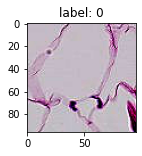

In [16]:
train_path = '../input/cancer-detection/train'

batch_train = 512
batch_val = 128

# Clean train image
train_img = ImageDataset(df=train, image_dir=train_path, transform=transform)                    
train_loader = DataLoader(dataset=train_img, batch_size=batch_train, shuffle=True)

# Noisy Image (for augmentation)
train_img_gaussian = ImageDataset(df=train, image_dir=train_path, transform=transform_gaussian)  # Only gaussian noise image
train_loader_gaussian = DataLoader(dataset=train_img_gaussian, batch_size=batch_train, shuffle=True)

# Clean validation image
val_img = ImageDataset(df=val, image_dir=train_path, transform=transform)
val_loader = DataLoader(dataset=val_img, batch_size=batch_val, shuffle=True)

# Noisy validation iamge
val_img_gaussian = ImageDataset(df=val, image_dir=train_path, transform=transform_gaussian)
val_loader_gaussian = DataLoader(dataset=val_img_gaussian, batch_size=batch_val, shuffle=True)

# Augmentation
train_img_augment = train_img + train_img_gaussian  # Augmented Train Dataset
train_loader_augment = DataLoader(dataset=train_img_augment, batch_size=batch_train, shuffle=True) # Augmented Train Dataloader

val_img_augment = val_img + val_img_gaussian        # Augmented Val Dataset
val_loader_augment = DataLoader(dataset=val_img_augment, batch_size=batch_val, shuffle=True)     # Augmented Val Dataloader

print("Train Size: ", len(train_img))
print("Augmented Train Size: ", len(train_img_augment))

image, label = val_img[202]
imshow(image, label) 

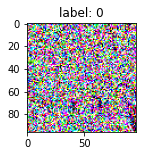

In [17]:
image, label = val_img_gaussian[202]
imshow(image, label)

## KNN Classification - Clean

In [18]:
# Training Data
X_train, y_train = iter(train_loader).next()
X_train_flat = (X_train.reshape(X_train.shape[0], 3 * 96 * 96))

# Validation Data
X_val, y_val = iter(val_loader).next()
X_val_flat = (X_val.reshape(X_val.shape[0], 3 * 96 * 96))

# Noisy Data
X_val_gaussian, y_val_gaussian = iter(val_loader_gaussian).next()
X_val_gaussian_flat = (X_val_gaussian.reshape(X_val_gaussian.shape[0], 3 * 96 * 96))

print(X_train_flat.shape)
print(y_train.shape)

print(X_val_flat.shape)
print(y_val.shape)

print(X_val_gaussian_flat.shape)
print(y_val_gaussian.shape)

torch.Size([512, 27648])
torch.Size([512])
torch.Size([128, 27648])
torch.Size([128])
torch.Size([128, 27648])
torch.Size([128])


In [19]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

num_epochs = 5

# for epoch in range(num_epochs+1):
    
# Train with clean data
model.fit(X_train_flat, y_train)

# Prediction on clean data
prediction = model.predict(X_val_flat)

# Prediction on noisy data
prediction_robust = model.predict(X_val_gaussian_flat)

y_val_list = y_val.tolist()
y_val_gaussian_list = y_val_gaussian.tolist()

print("Train with clean data")
print("")

print ('Clean Accuracy: %f' % (np.mean(prediction == y_val_list)))
print ('Robust Accuracy: %f' % (np.mean(prediction_robust == y_val_list)))
print("")

Train with clean data

Clean Accuracy: 0.656250
Robust Accuracy: 0.429688



## SVM Training

In [20]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with clean data
model.fit(X_train_flat, y_train)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))

SVM Training
Clearn Accuracy: 0.734375
Robust Accuracy: 0.5625


## SVM Robust Training

In [21]:
# Train with Augmented Dataset

X_train_augment, y_train_augment = iter(train_loader_augment).next()
X_train_flat_augment = (X_train_augment.reshape(X_train_augment.shape[0], 3 * 96 * 96))

print(X_train_flat_augment.shape)
print(y_train_augment.shape)

torch.Size([512, 27648])
torch.Size([512])


In [22]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with augmentation
model.fit(X_train_flat_augment, y_train_augment)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Robust Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))
print("")

SVM Robust Training
Clearn Accuracy: 0.703125
Robust Accuracy: 0.5625



In [23]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with just gaussian image
X_train_gaussian, y_train_gaussian = iter(train_loader_gaussian).next()
X_train_gaussian_flat = (X_train_gaussian.reshape(X_train_gaussian.shape[0], 3 * 96 * 96))

model.fit(X_train_gaussian_flat, y_train_gaussian)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Robust Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))
print("")

SVM Robust Training
Clearn Accuracy: 0.4296875
Robust Accuracy: 0.5859375



## KNN Classification - Robust Training

In [24]:
# Train with Augmented Dataset

X_train_augment, y_train_augment = iter(train_loader_augment).next()
X_train_flat_augment = (X_train_augment.reshape(X_train_augment.shape[0], 3 * 96 * 96))

print(X_train_flat.shape)
print(y_train_augment.shape)

torch.Size([512, 27648])
torch.Size([512])


In [25]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

# Train with augmented data
model.fit(X_train_flat_augment, y_train_augment)

# Prediction on clean data
prediction = model.predict(X_val_flat)

# Prediction on noisy data
prediction_robust = model.predict(X_val_gaussian_flat)

y_val_list = y_val.tolist()
y_val_gaussian_list = y_val_gaussian.tolist()

print ("After Augmented Training")
print("")

print ('Clean Accuracy: %f' % (np.mean(prediction == y_val_list)))
print ('Robust Accuracy: %f' % (np.mean(prediction_robust == y_val_list)))

After Augmented Training

Clean Accuracy: 0.687500
Robust Accuracy: 0.421875


## Resnet-18

In [26]:
import torchvision
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
from torchsummary import summary
summary(resnet18.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Modified Resnet-18

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class modified_resnet18(nn.Module):
    def __init__(self):
        super(modified_resnet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        
        for param in self.resnet18.parameters():
            param.requres_grad = False
            
        modified_fc = nn.Linear(in_features=512, out_features=2)
        self.resnet18.fc = modified_fc
    
    def forward(self, x):
        return self.resnet18(x)

In [30]:
summary(modified_resnet18().to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [31]:
modified_Resnet = modified_resnet18().cuda()
modified_Resnet

modified_resnet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [32]:
CUDA_LAUNCH_BLOCKING=1

## Pytorch FGSM Function

In [33]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [34]:
# from tqdm import tqdm


# def test( model, device, test_loader, epsilon ):

#     # Accuracy counter
#     correct = 0
#     adv_examples = []

#     # Loop over all examples in test set
#     for data, target in tqdm(test_loader):

#         # Send the data and label to the device
#         data, target = data.to(device), target.to(device)

#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True

#         # Forward pass the data through the model
#         output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#         # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

#         # Calculate the loss
#         loss = F.nll_loss(output, target)

#         # Zero all existing gradients
#         model.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()

#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)

#         # Re-classify the perturbed image
#         output = model(perturbed_data)

#         # Check for success
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if final_pred.item() == target.item():
#             correct += 1
#             # Special case for saving 0 epsilon examples
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

#     # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

#     # Return the accuracy and an adversarial example
#     return final_acc, adv_examples

In [35]:
# train_path = '../input/cancer-detection/train'

# # Clean validation image
# batch_val = 1
# val_df_fgsm = val[:2000]

# val_img_fgsm = ImageDataset(df=val_df_fgsm, image_dir=train_path, transform=transform)
# val_loader_fgsm = DataLoader(dataset=val_img_fgsm, batch_size=1, shuffle=True)

# image, label = val_img_fgsm[99]
# imshow(image, label) 

In [36]:
# accuracies = []
# examples = []

# epsilons = [0, .05, .1, .15, .2, .25, .3]

# model = modified_Resnet

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test(model, device, val_loader_fgsm, eps)
#     accuracies.append(acc)
#     examples.append(ex)

## Adversarial Training

### Check Torchattack Package and output (Data size = 1)

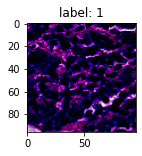

In [37]:
atk_df = train.head(1)
atk_dataset = ImageDataset(df=atk_df, image_dir=train_path, transform=transform)
atk_dataloader = DataLoader(dataset=atk_dataset, batch_size=1, shuffle=False)

image, label = atk_dataset[0]
imshow(image, label)

In [38]:
image, label = iter(atk_dataloader).next() 
image

tensor([[[[ 0.9373,  1.0000,  0.5373,  ..., -0.1765, -0.1608, -0.2627],
          [ 0.8980,  0.5686,  0.0353,  ..., -0.0902, -0.1529,  0.0667],
          [ 0.3725,  0.2000,  0.1059,  ...,  0.1059,  0.0275,  0.1608],
          ...,
          [ 0.7098,  0.8902,  0.8980,  ...,  0.3647,  0.0980,  0.3647],
          [ 0.7882,  0.7647,  0.6392,  ...,  0.4039,  0.1529,  0.2784],
          [ 0.7725,  0.9686,  0.7882,  ...,  0.5529,  0.3255,  0.3490]],

         [[ 0.4431,  0.5451,  0.0039,  ..., -0.5608, -0.6157, -0.7647],
          [ 0.4196,  0.0824, -0.4667,  ..., -0.5843, -0.7098, -0.5216],
          [-0.0667, -0.2706, -0.3882,  ..., -0.4353, -0.5765, -0.4824],
          ...,
          [ 0.5765,  0.7569,  0.7569,  ..., -0.1843, -0.4275, -0.1451],
          [ 0.6549,  0.6471,  0.5451,  ..., -0.1922, -0.5059, -0.3961],
          [ 0.6471,  0.8588,  0.7098,  ..., -0.0980, -0.4196, -0.4510]],

         [[ 0.8588,  1.0000,  0.5765,  ...,  0.2627,  0.2471,  0.1294],
          [ 0.8667,  0.5765,  

In [39]:
from torchattacks import *

In [40]:
model = modified_Resnet

In [41]:
atks = [
    FGSM(model, eps=0.9),
    BIM(model, eps=0.03, alpha=100, steps=100),
    RFGSM(model, eps=0.3, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

In [42]:
def imshow(image, label):
    image = image.cpu()
    label = str(label)
    plt.figure(figsize=(2, 2))
    plt.title("label: " + label)
    image = torch.squeeze(image, 0)
    print(image.shape)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

----------------------------------------------------------------------
FGSM(model_name=modified_resnet18, device=cuda:0, eps=0.9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


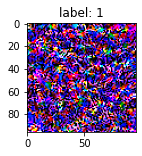

Total elapsed time (sec): 0.39
Robust accuracy: 100.00 %
----------------------------------------------------------------------
BIM(model_name=modified_resnet18, device=cuda:0, eps=0.03, alpha=100, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


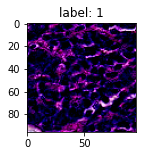

Total elapsed time (sec): 0.80
Robust accuracy: 100.00 %
----------------------------------------------------------------------
RFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.3, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


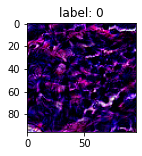

Total elapsed time (sec): 0.80
Robust accuracy: 0.00 %
----------------------------------------------------------------------
CW(model_name=modified_resnet18, device=cuda:0, c=1, kappa=0, steps=100, lr=0.01, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


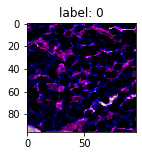

Total elapsed time (sec): 1.00
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.008888888888888889, steps=100, random_start=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


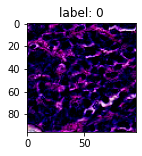

Total elapsed time (sec): 1.02
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGDL2(model_name=modified_resnet18, device=cuda:0, eps=1, alpha=0.2, steps=100, random_start=True, eps_for_division=1e-10, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


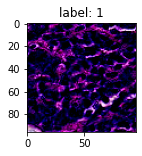

Total elapsed time (sec): 0.84
Robust accuracy: 100.00 %
----------------------------------------------------------------------
EOTPGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, eot_iter=2, random_start=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


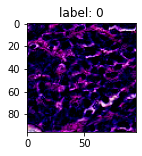

Total elapsed time (sec): 1.47
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


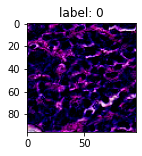

Total elapsed time (sec): 0.17
Robust accuracy: 0.00 %
----------------------------------------------------------------------
TPGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


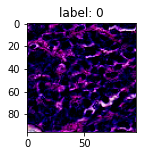

Total elapsed time (sec): 0.79
Robust accuracy: 0.00 %
----------------------------------------------------------------------
MIFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.1, alpha=0.00784313725490196, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


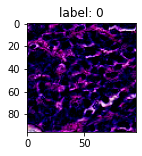

Total elapsed time (sec): 0.82
Robust accuracy: 0.00 %
----------------------------------------------------------------------
VANILA(model_name=modified_resnet18, device=cuda:0, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


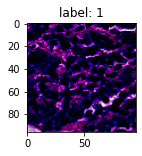

Total elapsed time (sec): 0.16
Robust accuracy: 100.00 %
----------------------------------------------------------------------
FAB(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


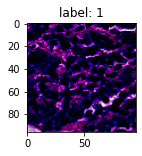

Total elapsed time (sec): 3.01
Robust accuracy: 100.00 %
----------------------------------------------------------------------
FAB(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


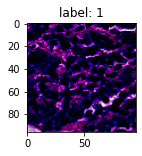

Total elapsed time (sec): 2.59
Robust accuracy: 100.00 %
----------------------------------------------------------------------
Square(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_queries=5000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


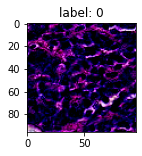

Total elapsed time (sec): 3.02
Robust accuracy: 0.00 %
----------------------------------------------------------------------
OnePixel(model_name=modified_resnet18, device=cuda:0, pixels=5, steps=75, popsize=400, inf_batch=50, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


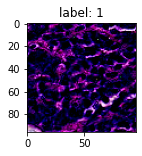

Total elapsed time (sec): 20.78
Robust accuracy: 100.00 %
----------------------------------------------------------------------
DeepFool(model_name=modified_resnet18, device=cuda:0, steps=100, overshoot=0.02, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


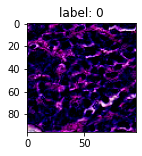

Total elapsed time (sec): 0.35
Robust accuracy: 0.00 %
----------------------------------------------------------------------
DIFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.0, alpha=0.00784313725490196, resize_rate=0.9, diversity_prob=0.5, random_start=False, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


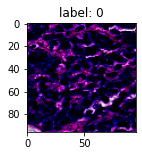

Total elapsed time (sec): 0.84
Robust accuracy: 0.00 %


In [43]:
import time
from tqdm import tqdm

model.eval()
for atk in atks:
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for image, label in atk_dataloader:
        
        start = time.time()
        adv_image = atk(image, label)
        label = label.to(device)
        outputs = model(adv_image)
        
        _,prediction = torch.max(outputs.data, 1)
        
        total += 1
        correct += (prediction == label).sum()
        prediction = prediction.cpu()
        adv_image = adv_image.cpu()
        
        prediction = int(prediction.item())
        imshow(adv_image, prediction)
    
    print("Total elapsed time (sec): %.2f" % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

## Adversarial Training (FGSM)

### Clean DataLoader

Size of dataset before augment:  176020
torch.Size([3, 96, 96])


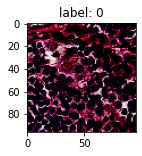

In [44]:
train_path = '../input/cancer-detection/train'

train_img = ImageDataset(df=train, image_dir=train_path, transform=transform)
val_img = ImageDataset(df=val, image_dir=train_path, transform=transform)

batch_train = 512
batch_val = 128

old_train_loader = DataLoader(dataset=train_img, batch_size=batch_train, shuffle=True)
val_loader = DataLoader(dataset=val_img, batch_size=batch_val, shuffle=False)

print("Size of dataset before augment: ", len(train_img))

image, label = train_img[39000]
imshow(image, label)

### 1.1 Normal Training

In [45]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print(device)

correct = 0
total = 0

# Normal Training
for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
    
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
        

cuda


 29%|██▉       | 99/344 [06:01<17:33,  4.30s/it]

Train accuracy: 89.55 %
Epoch [1/2], Iter [100/343], Loss: 0.2089


 58%|█████▊    | 199/344 [12:03<08:51,  3.66s/it]

Train accuracy: 91.48 %
Epoch [1/2], Iter [200/343], Loss: 0.1330


 87%|████████▋ | 299/344 [18:12<02:43,  3.64s/it]

Train accuracy: 92.36 %
Epoch [1/2], Iter [300/343], Loss: 0.1596


 29%|██▉       | 99/344 [01:48<04:37,  1.13s/it]

Train accuracy: 93.34 %
Epoch [2/2], Iter [100/343], Loss: 0.1290


 58%|█████▊    | 199/344 [03:40<02:56,  1.22s/it]

Train accuracy: 93.78 %
Epoch [2/2], Iter [200/343], Loss: 0.1337


 87%|████████▋ | 299/344 [05:36<00:55,  1.22s/it]

Train accuracy: 94.10 %
Epoch [2/2], Iter [300/343], Loss: 0.0952


100%|██████████| 344/344 [06:30<00:00,  1.14s/it]


### 1.1.1 Training with FGSM

In [46]:
# loss = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 2

# print(device)

# correct = 0
# total = 0
# atk = FGSM(model, eps=0.2)

# # Train with FGSM
# for epoch in range(num_epochs):
#     i = 0
#     model.train()
#     total_batch = len(train_img) // batch_train
    
#     for img, label in tqdm(old_train_loader):
#         img, label = img.to(device), label.to(device)
#         img = atk(img, label)

#         outputs = model(img)
#         cost = loss(outputs, label)

#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()
        
#         _, predicted = torch.max(outputs.data, 1)
        
#         total += label.size(0)
#         correct += (predicted == label).sum() 
#         i += 1
    
#         if (i+1) % 100 == 0:
#             print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
#             print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
        

### 1.2 Standard Accuracy

In [47]:
model.eval()

correct = 0
total = 0

for img, label in tqdm(val_loader):
    img = img.to(device)
    label = label.to(device)

    outputs = model(img)
    cost = loss(outputs, label)

    _, predicted = torch.max(outputs.data, 1)

    total += label.size(0)
    correct += (predicted == label).sum()
    i+=1

    if (i+1) % 100 == 0:
        print('Validation accuracy: %.2f %%' % (100 * float(correct) / total))
        print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))

 16%|█▌        | 55/344 [00:49<04:23,  1.10it/s]

Validation accuracy: 91.16 %
Epoch [2/2], Iter [400/343], Loss: 0.2495


 45%|████▌     | 155/344 [02:20<03:06,  1.01it/s]

Validation accuracy: 90.74 %
Epoch [2/2], Iter [500/343], Loss: 0.2242


 74%|███████▍  | 255/344 [03:53<01:19,  1.12it/s]

Validation accuracy: 90.67 %
Epoch [2/2], Iter [600/343], Loss: 0.1988


100%|██████████| 344/344 [05:15<00:00,  1.09it/s]


### 1.3 Robust Accuracy

In [48]:
model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.05)

for img, label in tqdm(val_loader):
    img = img.to(device)
    label = label.to(device)
    
    # Attack
    img = atk(img, label) 
    
    outputs = model(img)
    cost = loss(outputs, label)

    _, predicted = torch.max(outputs.data, 1)

    total += label.size(0)
    correct += (predicted == label).sum()
    i+=1

    if (i+1) % 100 == 0:
        print('Validation accuracy: %.2f %%' % (100 * float(correct) / total))
        print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))

  3%|▎         | 12/344 [00:02<01:08,  4.84it/s]

Validation accuracy: 45.17 %
Epoch [2/2], Iter [700/343], Loss: 2.1784


 33%|███▎      | 112/344 [00:22<00:47,  4.86it/s]

Validation accuracy: 46.09 %
Epoch [2/2], Iter [800/343], Loss: 2.5341


 62%|██████▏   | 212/344 [00:42<00:27,  4.85it/s]

Validation accuracy: 45.68 %
Epoch [2/2], Iter [900/343], Loss: 1.9701


 91%|█████████ | 312/344 [01:02<00:06,  4.88it/s]

Validation accuracy: 45.72 %
Epoch [2/2], Iter [1000/343], Loss: 2.2851


100%|██████████| 344/344 [01:09<00:00,  4.97it/s]


## Adversarial Training

In [49]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH attacked images")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.05)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH attacked images
cuda


 29%|██▉       | 99/344 [01:36<04:23,  1.07s/it]

Train accuracy: 66.83 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [03:26<03:07,  1.29s/it]

Train accuracy: 70.71 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [05:35<01:07,  1.50s/it]

Train accuracy: 72.13 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:27<03:54,  1.05it/s]

Train accuracy: 73.33 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:54<02:22,  1.01it/s]

Train accuracy: 73.94 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:19<00:41,  1.09it/s]

Train accuracy: 74.55 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [04:58<00:00,  1.15it/s]


## Adversarial Validation

In [50]:
# [Validation] Model trained WITH perturbed image
print("######## Test model trained WITH perturbed images ########")
print("Attack Method: FGSM")

correct = 0
total = 0

atk = FGSM(model, eps=0.05)

for epoch in range(num_epochs):
    i = 0
    print("Epoch: ", epoch+1)
    
    total_batch = len(val_img) // batch_val
    
    model.eval()
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))

######## Test model trained WITH perturbed images ########
Attack Method: FGSM
Epoch:  1


 29%|██▉       | 100/344 [00:19<00:50,  4.83it/s]

Robust accuracy: 76.55 %
Epoch [1/2], Iter [100/343], Loss: 0.4836


 58%|█████▊    | 200/344 [00:39<00:30,  4.70it/s]

Robust accuracy: 76.49 %
Epoch [1/2], Iter [200/343], Loss: 0.5412


 87%|████████▋ | 300/344 [00:58<00:08,  4.95it/s]

Robust accuracy: 76.35 %
Epoch [1/2], Iter [300/343], Loss: 0.4677


100%|██████████| 344/344 [01:07<00:00,  5.11it/s]


Epoch:  2


 29%|██▉       | 100/344 [00:19<00:49,  4.89it/s]

Robust accuracy: 76.44 %
Epoch [2/2], Iter [100/343], Loss: 0.4836


 58%|█████▊    | 200/344 [00:39<00:30,  4.68it/s]

Robust accuracy: 76.44 %
Epoch [2/2], Iter [200/343], Loss: 0.5412


 87%|████████▋ | 300/344 [00:58<00:08,  4.96it/s]

Robust accuracy: 76.38 %
Epoch [2/2], Iter [300/343], Loss: 0.4677


100%|██████████| 344/344 [01:07<00:00,  5.12it/s]


In [51]:
# [Validation] Model trained WITH perturbed image
print("######## Test model trained WITH perturbed images ########")
print("Attack Method: FGSM")

correct = 0
total = 0

atk = FGSM(model, eps=0.1)

i = 0
total_batch = len(val_img) // batch_val
model.eval()

for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)

    img = atk(img, label) # FGSM attack

    outputs = model(img)
    cost = loss(outputs, label)

    _, predicted = torch.max(outputs.data, 1)

    total += label.size(0)
    correct += (predicted == label).sum()
    i+=1

    if (i+1) % 100 == 0:
        print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
        print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
        print("")

######## Test model trained WITH perturbed images ########
Attack Method: FGSM


 29%|██▉       | 100/344 [00:19<00:48,  5.07it/s]

Robust accuracy: 71.53 %
Epoch [2/2], Iter [100/343], Loss: 0.5594



 58%|█████▊    | 199/344 [00:39<00:30,  4.71it/s]

Robust accuracy: 71.82 %
Epoch [2/2], Iter [200/343], Loss: 0.6324



 87%|████████▋ | 300/344 [00:58<00:08,  4.96it/s]

Robust accuracy: 71.57 %
Epoch [2/2], Iter [300/343], Loss: 0.5376



100%|██████████| 344/344 [01:07<00:00,  5.11it/s]


In [52]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH attacked images")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.1)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH attacked images
cuda


 29%|██▉       | 99/344 [01:25<03:58,  1.03it/s]

Train accuracy: 68.89 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:54<02:21,  1.02it/s]

Train accuracy: 69.70 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:22<00:44,  1.02it/s]

Train accuracy: 70.59 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:25<03:49,  1.07it/s]

Train accuracy: 71.98 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:52<02:12,  1.10it/s]

Train accuracy: 73.20 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:19<00:42,  1.06it/s]

Train accuracy: 75.08 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [04:57<00:00,  1.16it/s]


In [53]:
# [Validation] Model trained WITH perturbed image
print("######## Test model trained WITH perturbed images ########")
print("Attack Method: FGSM")


epsilons = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
            print("")

######## Test model trained WITH perturbed images ########
Attack Method: FGSM
Epsilon:  0


 29%|██▉       | 100/344 [00:19<00:49,  4.96it/s]

Robust accuracy: 72.52 %
Epoch [2/2], Iter [100/343], Loss: 0.8686



 58%|█████▊    | 200/344 [00:38<00:29,  4.95it/s]

Robust accuracy: 72.68 %
Epoch [2/2], Iter [200/343], Loss: 0.8729



 87%|████████▋ | 300/344 [00:58<00:08,  4.92it/s]

Robust accuracy: 72.34 %
Epoch [2/2], Iter [300/343], Loss: 0.7310



100%|██████████| 344/344 [01:07<00:00,  5.11it/s]


Epsilon:  0.05


 29%|██▉       | 100/344 [00:19<00:52,  4.62it/s]

Robust accuracy: 83.49 %
Epoch [2/2], Iter [100/343], Loss: 0.3454



 58%|█████▊    | 200/344 [00:39<00:29,  4.86it/s]

Robust accuracy: 83.47 %
Epoch [2/2], Iter [200/343], Loss: 0.4111



 87%|████████▋ | 300/344 [00:59<00:09,  4.87it/s]

Robust accuracy: 83.32 %
Epoch [2/2], Iter [300/343], Loss: 0.3536



100%|██████████| 344/344 [01:08<00:00,  5.06it/s]


Epsilon:  0.1


 29%|██▉       | 100/344 [00:19<00:49,  4.90it/s]

Robust accuracy: 81.32 %
Epoch [2/2], Iter [100/343], Loss: 0.2911



 58%|█████▊    | 200/344 [00:39<00:30,  4.65it/s]

Robust accuracy: 81.62 %
Epoch [2/2], Iter [200/343], Loss: 0.3790



 87%|████████▋ | 300/344 [00:59<00:08,  4.96it/s]

Robust accuracy: 81.34 %
Epoch [2/2], Iter [300/343], Loss: 0.3260



100%|██████████| 344/344 [01:08<00:00,  5.02it/s]


Epsilon:  0.15


 29%|██▉       | 100/344 [00:19<00:53,  4.55it/s]

Robust accuracy: 70.38 %
Epoch [2/2], Iter [100/343], Loss: 0.6451



 58%|█████▊    | 200/344 [00:39<00:29,  4.89it/s]

Robust accuracy: 70.38 %
Epoch [2/2], Iter [200/343], Loss: 0.8751



 87%|████████▋ | 300/344 [00:58<00:10,  4.39it/s]

Robust accuracy: 70.17 %
Epoch [2/2], Iter [300/343], Loss: 0.7563



100%|██████████| 344/344 [01:07<00:00,  5.13it/s]


Epsilon:  0.2


 29%|██▉       | 100/344 [00:19<00:49,  4.97it/s]

Robust accuracy: 65.12 %
Epoch [2/2], Iter [100/343], Loss: 1.0160



 58%|█████▊    | 200/344 [00:40<00:29,  4.89it/s]

Robust accuracy: 64.91 %
Epoch [2/2], Iter [200/343], Loss: 1.5157



 87%|████████▋ | 300/344 [00:59<00:08,  4.89it/s]

Robust accuracy: 64.67 %
Epoch [2/2], Iter [300/343], Loss: 1.3075



100%|██████████| 344/344 [01:08<00:00,  5.04it/s]


Epsilon:  0.25


 29%|██▉       | 100/344 [00:20<00:50,  4.86it/s]

Robust accuracy: 60.83 %
Epoch [2/2], Iter [100/343], Loss: 1.3268



 58%|█████▊    | 200/344 [00:40<00:29,  4.89it/s]

Robust accuracy: 60.54 %
Epoch [2/2], Iter [200/343], Loss: 2.0002



 87%|████████▋ | 300/344 [01:00<00:08,  4.89it/s]

Robust accuracy: 60.48 %
Epoch [2/2], Iter [300/343], Loss: 1.7034



100%|██████████| 344/344 [01:08<00:00,  4.99it/s]


Epsilon:  0.3


 29%|██▉       | 100/344 [00:19<00:53,  4.57it/s]

Robust accuracy: 57.63 %
Epoch [2/2], Iter [100/343], Loss: 1.5536



 58%|█████▊    | 200/344 [00:38<00:29,  4.92it/s]

Robust accuracy: 57.32 %
Epoch [2/2], Iter [200/343], Loss: 2.1946



 87%|████████▋ | 300/344 [00:58<00:08,  4.89it/s]

Robust accuracy: 57.18 %
Epoch [2/2], Iter [300/343], Loss: 1.8146



100%|██████████| 344/344 [01:07<00:00,  5.13it/s]


In [54]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH attacked images")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.9)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH attacked images
cuda


 29%|██▉       | 99/344 [01:27<04:01,  1.01it/s]

Train accuracy: 67.47 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:57<02:20,  1.03it/s]

Train accuracy: 72.88 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:35<00:50,  1.13s/it]

Train accuracy: 78.47 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:27<03:52,  1.05it/s]

Train accuracy: 73.87 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:56<02:20,  1.03it/s]

Train accuracy: 71.27 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:25<00:44,  1.02it/s]

Train accuracy: 70.56 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [05:04<00:00,  1.13it/s]


In [56]:
# [Validation] Model trained WITH perturbed image
print("######## Test model trained WITH perturbed images ########")
print("Attack Method: FGSM")


epsilons = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
    print("")

######## Test model trained WITH perturbed images ########
Attack Method: FGSM
Epsilon:  0


 29%|██▉       | 99/344 [00:30<01:22,  2.98it/s]

Robust accuracy: 63.39 %
Epoch [2/2], Iter [100/343], Loss: 1.0243


 58%|█████▊    | 199/344 [01:00<00:46,  3.09it/s]

Robust accuracy: 63.60 %
Epoch [2/2], Iter [200/343], Loss: 0.7188


 87%|████████▋ | 299/344 [01:30<00:14,  3.16it/s]

Robust accuracy: 63.24 %
Epoch [2/2], Iter [300/343], Loss: 0.8145


100%|██████████| 344/344 [01:44<00:00,  3.30it/s]



Epsilon:  0.05


 29%|██▉       | 100/344 [00:19<00:49,  4.94it/s]

Robust accuracy: 55.15 %
Epoch [2/2], Iter [100/343], Loss: 1.2163


 58%|█████▊    | 200/344 [00:38<00:28,  4.97it/s]

Robust accuracy: 55.38 %
Epoch [2/2], Iter [200/343], Loss: 0.9112


 87%|████████▋ | 300/344 [00:58<00:09,  4.82it/s]

Robust accuracy: 55.02 %
Epoch [2/2], Iter [300/343], Loss: 1.0720


100%|██████████| 344/344 [01:07<00:00,  5.11it/s]



Epsilon:  0.1


 29%|██▉       | 100/344 [00:20<00:50,  4.79it/s]

Robust accuracy: 48.28 %
Epoch [2/2], Iter [100/343], Loss: 1.3955


 58%|█████▊    | 200/344 [00:40<00:29,  4.88it/s]

Robust accuracy: 48.48 %
Epoch [2/2], Iter [200/343], Loss: 1.0548


 87%|████████▋ | 299/344 [01:00<00:09,  4.69it/s]

Robust accuracy: 48.23 %
Epoch [2/2], Iter [300/343], Loss: 1.2934


100%|██████████| 344/344 [01:09<00:00,  4.96it/s]



Epsilon:  0.15


 29%|██▉       | 100/344 [00:20<00:55,  4.37it/s]

Robust accuracy: 42.04 %
Epoch [2/2], Iter [100/343], Loss: 1.5158


 58%|█████▊    | 200/344 [00:39<00:29,  4.88it/s]

Robust accuracy: 42.18 %
Epoch [2/2], Iter [200/343], Loss: 1.1818


 87%|████████▋ | 300/344 [00:58<00:08,  4.95it/s]

Robust accuracy: 41.92 %
Epoch [2/2], Iter [300/343], Loss: 1.4377


100%|██████████| 344/344 [01:07<00:00,  5.12it/s]



Epsilon:  0.2


 29%|██▉       | 100/344 [00:20<00:50,  4.79it/s]

Robust accuracy: 37.03 %
Epoch [2/2], Iter [100/343], Loss: 1.5756


 58%|█████▊    | 200/344 [00:39<00:29,  4.81it/s]

Robust accuracy: 37.07 %
Epoch [2/2], Iter [200/343], Loss: 1.2678


 87%|████████▋ | 300/344 [00:59<00:09,  4.86it/s]

Robust accuracy: 37.04 %
Epoch [2/2], Iter [300/343], Loss: 1.5068


100%|██████████| 344/344 [01:08<00:00,  5.03it/s]



Epsilon:  0.25


 29%|██▉       | 100/344 [00:20<00:49,  4.97it/s]

Robust accuracy: 35.04 %
Epoch [2/2], Iter [100/343], Loss: 1.5840


 58%|█████▊    | 200/344 [00:40<00:30,  4.67it/s]

Robust accuracy: 34.97 %
Epoch [2/2], Iter [200/343], Loss: 1.3049


 87%|████████▋ | 299/344 [01:00<00:11,  4.06it/s]

Robust accuracy: 34.96 %
Epoch [2/2], Iter [300/343], Loss: 1.5076


100%|██████████| 344/344 [01:09<00:00,  4.98it/s]



Epsilon:  0.3


 29%|██▉       | 100/344 [00:20<00:50,  4.86it/s]

Robust accuracy: 34.58 %
Epoch [2/2], Iter [100/343], Loss: 1.5586


 58%|█████▊    | 200/344 [00:40<00:29,  4.84it/s]

Robust accuracy: 34.73 %
Epoch [2/2], Iter [200/343], Loss: 1.3093


 87%|████████▋ | 300/344 [01:00<00:09,  4.86it/s]

Robust accuracy: 34.85 %
Epoch [2/2], Iter [300/343], Loss: 1.4554


100%|██████████| 344/344 [01:09<00:00,  4.94it/s]

In [57]:
# [Validation] Model trained WITH perturbed image
print("######## Test model trained WITH perturbed images ########")
print("Attack Method: FGSM")


epsilons = [0.9]

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
    print("")

######## Test model trained WITH perturbed images ########
Attack Method: FGSM
Epsilon:  0.9


 29%|██▉       | 99/344 [00:19<00:55,  4.44it/s]

Robust accuracy: 79.88 %
Epoch [2/2], Iter [100/343], Loss: 0.6357


 58%|█████▊    | 200/344 [00:39<00:29,  4.92it/s]

Robust accuracy: 79.87 %
Epoch [2/2], Iter [200/343], Loss: 0.5070


 87%|████████▋ | 300/344 [00:59<00:09,  4.81it/s]

Robust accuracy: 79.90 %
Epoch [2/2], Iter [300/343], Loss: 0.5408


100%|██████████| 344/344 [01:08<00:00,  5.02it/s]